In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os
import json
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
def readData():
    dataFolder = "./data/"
    files = os.listdir(dataFolder)
    data = []
    for file in files:
        path = dataFolder + file
        with open(path, "r") as f:
            raw = f.read()
            raw = raw.split("\n")
            for singleRaw in raw[:-1]:
                datapoint = json.loads(singleRaw)
                readings = datapoint["data"]
                hz = len(readings) / ((readings[-1][0] - readings[0][0]) * 10**-9)  # timestamp is in nanoseconds
                if (hz > 40):
                    data += [datapoint]
    return data

data = readData()

In [3]:

def normalise(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu) / sigma

def convertData(data):
    X, T, truth, misc = [], [], [], []
    for d in data:
        id = d["id"]
        drunk = d["drunk"]
        walking = d["walking"]
        readings = d["data"]
        firstTimestamp = readings[0][0]
        convertedReadings = []
        timestamps = []
        for r in readings:
            t, x, y, z = r
            timestamp = t - firstTimestamp  # slide so all timestamps start at 0
            if timestamp < 30 * 10**9 and len(convertedReadings)<1200:
                convertedReadings += [ [x, y, z] ]
                timestamps += [t]
            if timestamp < 0:
                break
        else:
            if len(convertedReadings) == 1200:
                X += [normalise(np.array(convertedReadings))]
                T += [timestamps]
                truth += [drunk]
                misc += [id, walking]
    X = np.array(X)
    T = np.array(T)
    truth = np.array(truth).astype(int)
    truthOnehot = np.zeros((truth.size, 2))
    truthOnehot[np.arange(truth.size), truth] = 1
    misc = np.array(misc)
    return X, T, truthOnehot, misc



X, T, y, misc = convertData(data)

In [4]:
def getTrainTestSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = getTrainTestSplit(X, y)


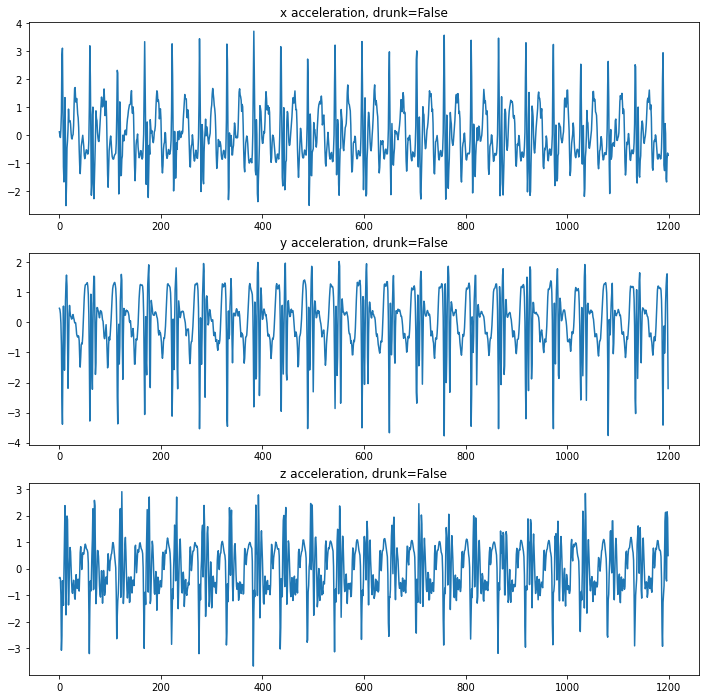

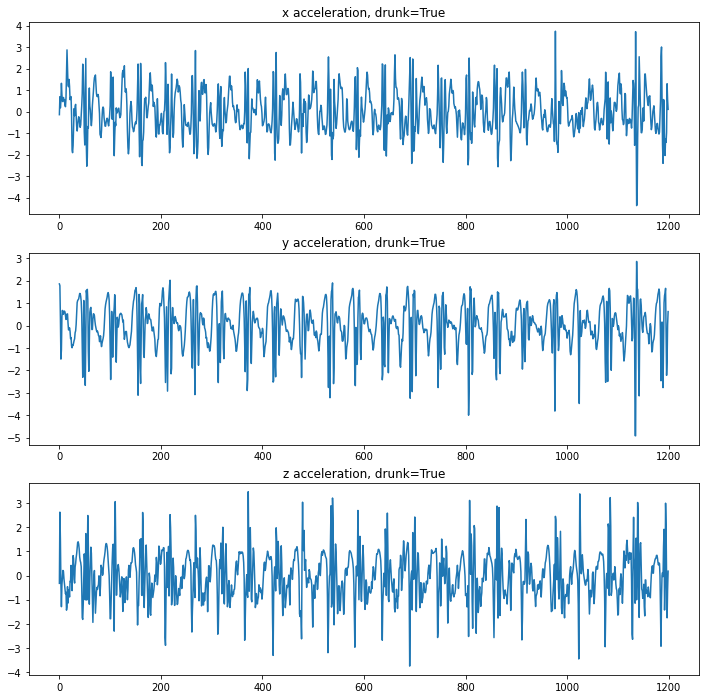

In [5]:
def plot(ax, y, title):
    ax.plot([i for i in range(len(y))], y)
    ax.set_title(title)
    #ax.title = title

def plotdata(X, T, y):
    for option in range(y.shape[1]):
        series = random.choice(X[y.T[option]==1])
        fig, axes = plt.subplots(nrows=3, figsize=(12,12))
        for ax, vals, label in zip(axes, series.T, "xyz"):
            plot(ax, vals, f"{label} acceleration, drunk={option==1}")

plotdata(X, T, y)



In [8]:
def trainModel(X, y):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=6, batch_size=32)

    return model

model = trainModel(X_train, y_train)
model.evaluate(X_test, y_test, batch_size=32, verbose=0)

Epoch 1/6
10/10 [==============================] - 2s 119ms/step - loss: 2.2727 - accuracy: 0.4272
Epoch 2/6
10/10 [==============================] - 1s 118ms/step - loss: 0.6889 - accuracy: 0.6505
Epoch 3/6
10/10 [==============================] - 1s 119ms/step - loss: 0.6830 - accuracy: 0.6440
Epoch 4/6
10/10 [==============================] - 1s 121ms/step - loss: 0.6476 - accuracy: 0.6440
Epoch 5/6
10/10 [==============================] - 1s 122ms/step - loss: 0.5309 - accuracy: 0.7702
Epoch 6/6
10/10 [==============================] - 1s 117ms/step - loss: 0.3045 - accuracy: 0.9029


[0.37338700890541077, 0.8974359035491943]

In [27]:


# run an experiment
def run_experiment(X_train, y_train, X_test, y_test, repeats=10):
	# repeat experiment
	scores = []
	for r in range(repeats):
		model = trainModel(X_train, y_train)
		_, score = model.evaluate(X_test, y_test)

		y_pred = model.predict(X_test)
		y_pred = y_pred.round()
		accuracy = metrics.accuracy_score(y_test, y_pred)
		precision = metrics.precision_score(y_test, y_pred, average="macro")
		recall = metrics.recall_score(y_test, y_pred, average="macro")
		
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append([accuracy, precision, recall])
	# summarize results
	return scores


# run the experiment
scores = run_experiment(X_train, y_train, X_test, y_test)

Epoch 1/6
10/10 [==============================] - 2s 131ms/step - loss: 2.1371 - accuracy: 0.5146
Epoch 2/6
10/10 [==============================] - 1s 132ms/step - loss: 0.7028 - accuracy: 0.4207
Epoch 3/6
10/10 [==============================] - 1s 134ms/step - loss: 0.6487 - accuracy: 0.6828
Epoch 4/6
10/10 [==============================] - 1s 142ms/step - loss: 0.5915 - accuracy: 0.6926
Epoch 5/6
10/10 [==============================] - 1s 133ms/step - loss: 0.4507 - accuracy: 0.8511
Epoch 6/6
3/3 [==============================] - 0s 20ms/step - loss: 0.3987 - accuracy: 0.8718
>#1: 87.179
Epoch 1/6
10/10 [==============================] - 2s 125ms/step - loss: 2.0154 - accuracy: 0.5534
Epoch 2/6
10/10 [==============================] - 1s 131ms/step - loss: 0.5752 - accuracy: 0.6699
Epoch 3/6
10/10 [==============================] - 1s 130ms/step - loss: 0.3825 - accuracy: 0.8835
Epoch 4/6
10/10 [==============================] - 1s 126ms/step - loss: 0.2229 - accuracy: 0.9320
E

In [28]:
def summarize_results(scores):
	s = np.array(scores)
	#m, s = np.mean(scores), np.std(scores)
	chosenMetrics = ["accuracy ", 
					 "precision", 
					 "recall   "]
	mean = s.mean(axis=0)
	std = s.std(axis=0)
	for m, v, d in zip(chosenMetrics, mean, std):
		print(f"{m}: {v :.3f} (+- {d :.3f})")
	#print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

summarize_results(scores)
scores

accuracy : 0.821 (+- 0.093)
precision: 0.840 (+- 0.053)
recall   : 0.823 (+- 0.080)


[[0.8717948717948718, 0.878968253968254, 0.8830213903743316],
 [0.8974358974358975, 0.8960526315789473, 0.9024064171122994],
 [0.8205128205128205, 0.8365384615384615, 0.804144385026738],
 [0.8333333333333334, 0.8333333333333334, 0.838903743315508],
 [0.8205128205128205, 0.8174603174603174, 0.820855614973262],
 [0.8589743589743589, 0.8747276688453158, 0.8449197860962567],
 [0.8717948717948718, 0.8842857142857143, 0.8596256684491979],
 [0.5512820512820513, 0.7008141112618724, 0.5989304812834224],
 [0.8589743589743589, 0.8566249176005274, 0.8616310160427807],
 [0.8205128205128205, 0.8192934782608696, 0.8141711229946524]]